In [16]:
import cv2
import imutils
import numpy as np
import pdb
from matplotlib import pyplot as plt


import csv
import ast
import sys

In [17]:
#################### X-Y CONVENTIONS #########################
# 0,0  X  > > > > >
#
#  Y
#
#  v  This is the image. Y increases downwards, X increases rightwards
#  v  Please return bounding boxes as ((xmin, ymin), (xmax, ymax))
#  v
#  v
#  v
###############################################################

In [18]:
def image_print(img):
    """
    Helper function to print out images, for debugging.
    Press any key to continue.
    """
    winname = "Image"
    cv2.namedWindow(winname)        # Create a named window
    cv2.moveWindow(winname, 40,30)  # Move it to (40,30)
    cv2.imshow(winname, img)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [19]:
def cd_template_matching(img, template):
    """
    Implement the cone detection using template matching algorithm
    Input:
        img: np.3darray; the input image with a cone to be detected
    Return:
        bbox: ((x1, y1), (x2, y2)); the bounding box of the cone, unit in px
                (x1, y1) is the bottom left of the bbox and (x2, y2) is the top right of the bbox
    """
    template_canny = cv2.Canny(template, 50, 200)

    # Perform Canny Edge detection on test image
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(grey_img, 50, 200)

    # Get dimensions of template
    (img_height, img_width) = img_canny.shape[:2]

    # check 6 different methods for template matching
    # tracking
    best_val = None # (max_val, top_left_coord, bottom_right_coord)
    
    # Loop over different scales of image
    for scale in np.linspace(1.5, .5, 50):
        # Resize the image
        resized_template = imutils.resize(template_canny, width = int(template_canny.shape[1] * scale))
        (h,w) = resized_template.shape[:2]
        
        # Check to see if test image is now smaller than template image
        if resized_template.shape[0] > img_height or resized_template.shape[1] > img_width:
            continue

        ########## YOUR CODE STARTS HERE ##########
        # Use OpenCV template matching functions to find the best match
        # across template scales.

        else: # perform template matching
            method = cv2.TM_CCOEFF_NORMED
            res = cv2.matchTemplate(img_canny,resized_template,method)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

            # for TM_CCOEFF_NORMED method, take max
            if (best_val is None) or (max_val > best_val[0]):
                best_val = (max_val, max_loc, (max_loc[0] + w, max_loc[1] + h))

#     cv2.rectangle(img_canny,best_val[1], best_val[2], 255, 2)

#     plt.subplot(121),plt.imshow(res,cmap = 'gray')
#     plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
#     plt.subplot(122),plt.imshow(img_canny,cmap = 'gray')
#     plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    
    bounding_box = (best_val[1], best_val[2])

#     plt.show()
    final_width = best_val[2][0] - best_val[1][0]
    final_height = best_val[2][1] - best_val[1][1]
#     print("resized dimensions, height:", final_height, "width:", final_width)
    return bounding_box

In [ ]:
def cd_sift_ransac(img, template):
    """
    Implement the cone detection using SIFT + RANSAC algorithm
    Input:
        img: np.3darray; the input image with a cone to be detected
    Return:
        bbox: ((x1, y1), (x2, y2)); the bounding box of the cone, unit in px
            (x1, y1) is the bottom left of the bbox and (x2, y2) is the top right of the bbox
    """
    # Minimum number of matching features
    MIN_MATCH = 10
    # Create SIFT
#     sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.SIFT_create()
#     sift = cv2.ORB_create()

    # Compute SIFT on template and test image
    kp1, des1 = sift.detectAndCompute(template,None)
    kp2, des2 = sift.detectAndCompute(img,None)

    # Find matches
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)

    # Find and store good matches
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    # If enough good matches, find bounding box
    if len(good) > MIN_MATCH:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        # Create mask
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

#         h, w = template.shape
        h, w = template.shape[:2] #changed from above
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        ########## YOUR CODE STARTS HERE ##########
        
        dst = cv2.perspectiveTransform(pts,M)

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)

        # draws matches
#         img3 = cv2.drawMatches(template,kp1,img,kp2,good, None,**draw_params)

        # Draw bounding box in Red
#         img3 = cv2.polylines(img, [np.int32(dst)], True, (0,0,255),3, cv2.LINE_AA)
#         cv2.imshow("result", img3)
#         cv2.waitKey()

        # get bounding box
        contours = np.int32(dst)       
        all_x = [i[0][0] for i in contours]
        all_y = [i[0][1] for i in contours] 
        x_min = min(all_x)
        x_max = max(all_x)
        y_min = min(all_y)
        y_max = max(all_y)

        ########### YOUR CODE ENDS HERE ###########

        # Return bounding box
        return ((x_min, y_min), (x_max, y_max))
    else:

        print("[SIFT] not enough matches; matches: ", len(good))

        # Return bounding box of area 0 if no match found
        return ((0,0), (0,0))

In [ ]:
import cv2
import numpy as np
import pdb

#################### X-Y CONVENTIONS #########################
# 0,0  X  > > > > >
#
#  Y
#
#  v  This is the image. Y increases downwards, X increases rightwards
#  v  Please return bounding boxes as ((xmin, ymin), (xmax, ymax))
#  v
#  v
#  v
###############################################################

def image_print(img):
    """
    Helper function to print out images, for debugging. Pass them in as a list.
    Press any key to continue.
    """
    cv2.imshow("image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def lookupBounds(x):
    if x == 1:	# decent mask, noise
        lower_bound = np.array([5,80,80])
        upper_bound = np.array([20,255,255])
    elif x == 2: # better mask, less noise, not sensitive to lighter orange
        lower_bound = np.array([10,100,100])
        upper_bound = np.array([16,255,255])
    elif x == 3: # similar to 2, VERY low noise (might be functional)
        lower_bound = np.array([10,150,150])
        upper_bound = np.array([16,255,255])
    elif x == 4: # similar to 3 but more agressive on eliminating noise
        lower_bound = np.array([5,150,200])
        upper_bound = np.array([20,255,255])
    elif x == 5: # similar to 4 but more sensitive to lighter oranges, prob best alone
        lower_bound = np.array([5,180,190])
        upper_bound = np.array([25,255,255])
    elif x == 6: # similar to 5 but more sensitive to lighter oranges, probably the best so far with erode and dilate. Good with 1 and 2 iters. 
        lower_bound = np.array([5,180,190]) # 180 on the last!
        upper_bound = np.array([35,255,255])
    elif x == 7: # similar to 5 but more sensitive to lighter oranges, probably the best so far with erode and dilate. Good with 2 and 5 iters. 
        lower_bound = np.array([5,180,190])
        upper_bound = np.array([35,255,255])
    return [lower_bound,upper_bound]


def cd_color_segmentation(img, template):
    """
    Implement the cone detection using color segmentation algorithm
    Input:
        img: np.3darray; the input image with a cone to be detected. BGR.
        template_file_path; Not required, but can optionally be used to automate setting hue filter values.
    Return:
        bbox: ((x1, y1), (x2, y2)); the bounding box of the cone, unit in px
                (x1, y1) is the top left of the bbox and (x2, y2) is the bottom right of the bbox
    """

    # PARAMS
    ########
    # decent combos: bounds=6, 1 iter, 2 iter || bounds=7, 2 iter, 6 iter
    viz_original_img = False
    viz_masked_img = False
    viz_eroded = False
    viz_dilated = False
    viz_box = True
    set_bounds = 7 # 1,2,3,4,5,6

    # BEGIN CODE 
    ############
    if viz_original_img:
        image_print(img) # see original image

    # step 1: convert to HSV color scheme (more robust to changes in illumination... img shape is like [[[H,S,V]...]...]
    image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # step 2: use cv2.inRange to bound the HSV values, only keeping what is useful (orange). Perhaps improve ranges. 
    bounds = lookupBounds(set_bounds)
    imagemask = cv2.inRange(image,bounds[0],bounds[1])
    if viz_masked_img:
        image_print(imagemask)

    # step 3: use erosion and dilution
    kernel1 = np.ones((5,5), np.uint8)
    image_erod = cv2.erode(imagemask,kernel1,iterations=2) # 1 # 2
    if viz_eroded:
        image_print(image_erod)
    image_dila = cv2.dilate(image_erod,kernel1,iterations=5) # 2 # 6
    if viz_dilated:
        image_print(image_dila)

    # step 4: get contours
    ret,thresh = cv2.threshold(image_dila,127,255,0)
    contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[-1]

    # step 5: get bounding box
    x,y,w,h = cv2.boundingRect(cnt)
    bounding_box = ((x,y),(x+w,y+h))

    # step 6: display original img with bounding rectangle!
    img = cv2.rectangle(img,bounding_box[0],bounding_box[1],(0,255,0),2)
    if viz_box:
        image_print(img)

    # Return bounding box
    return bounding_box


### Testing

simple testing for template matching:

In [ ]:
# File paths
cone_template_path = "./test_images_cone/cone_template.png"
cone_pic_path = "./test_images_cone/test5.jpg"

cone_template_img = cv2.imread(cone_template_path)
cone_img = cv2.imread(cone_pic_path)

# show image
plt.imshow(cone_img)
plt.show()

cd_template_matching(cone_img, cone_template_img)

simple testing for sift:

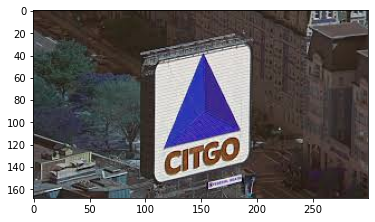

In [ ]:
# File paths
citgo_template_path = "./test_images_citgo/citgo_template.png"
citgo_pic_path = "./test_images_citgo/citgo6.jpeg"

citgo_template_img = cv2.imread(citgo_template_path)
citgo_img = cv2.imread(citgo_pic_path)

# show image
plt.imshow(citgo_img)
plt.show()

cd_sift_ransac(citgo_img, citgo_template_img)

In [37]:
# File paths
cone_csv_path = "./test_images_cone/test_images_cone.csv"
citgo_csv_path = "./test_images_citgo/test_citgo.csv"
localization_csv_path="./test_images_localization/test_localization.csv"

cone_template_path = './test_images_cone/cone_template.png'
citgo_template_path = './test_images_citgo/citgo_template.png'
localization_template_path='./test_images_localization/basement_fixed.png'

# cone_score_path = './scores/test_scores_cone.csv'
# citgo_score_path = './scores/test_scores_citgo.csv'
# localization_score_path = './scores/test_scores_map.csv'

cone_score_path = 'test_scores_cone.csv'
citgo_score_path = 'test_scores_citgo.csv'
localization_score_path = 'test_scores_map.csv'

def iou_score(bbox1, bbox2):
    """
    Return the IoU score for the two bounding boxes
    Input:
        bbox1: ((x1, y1), (x2, y2)); the bounding box of the cone, unit in px
                (x1, y1) is the top left of the bbox and (x2, y2) is the bottom right of the bbox
        bbox2: ((x1, y1), (x2, y2)); the bounding box of the cone, unit in px
                (x1, y1) is the top left of the bbox and (x2, y2) is the bottom right of the bbox
    Return:
        score: float; the IoU score
    """
    # First check bbox is coming in the correct order
    if bbox1[0][0] > bbox1[1][0] or bbox1[0][1] > bbox1[1][1]:
        print ("Check that you are returning bboxes as ((xmin, ymin),(xmax,ymax))")
    # Determine intersection rectangle
    x_int_1 = max(bbox1[0][0], bbox2[0][0])
    y_int_1 = max(bbox1[0][1], bbox2[0][1])
    x_int_2 = min(bbox1[1][0], bbox2[1][0])
    y_int_2 = min(bbox1[1][1], bbox2[1][1])

    # Compute area of intersection
    
    # Check if the bounding boxes are disjoint (no intersection)
    if x_int_2 - x_int_1 < 0 or y_int_2 - y_int_1 < 0:
        area_int = 0
    else:
        area_int = (x_int_2 - x_int_1 + 1) * (y_int_2 - y_int_1 + 1)
    
    # Compute area of both bounding boxes
    area_bbox1 = (bbox1[1][0] - bbox1[0][0] + 1) * (bbox1[1][1] - bbox1[0][1] + 1)
    area_bbox2 = (bbox2[1][0] - bbox2[0][0] + 1) * (bbox2[1][1] - bbox2[0][1] + 1)

    # Compute area of union
    area_union = float(area_bbox1 + area_bbox2 - area_int)

    # Compute and return IoU score
    score = area_int / area_union

    # Reject negative scores
    if score < 0:
        score = 0

    return score

def test_algorithm(detection_func, csv_file_path, template_file_path, swap=False):
    """
    Test a cone detection function and return the average score based on all the test images
    Input:
        detection_func: func; the cone detection function that takes the np.3darray
                as input and return (bottom, left, top, right) as output
        csv_file_path: string; the path to the csv file
        template_file_path: string, path to template file
        swap: Optional tag for indicating the template_file is really the background file
        For the map template matching, these need to be inverted
    Return:
        scores: dict; the score for each test image
    """
    # Keep track of scores
    scores = {}
    # Open test images csv
    with open(csv_file_path) as csvDataFile:
        csvReader = csv.reader(csvDataFile)
        # Iterate through all test images
        for row in csvReader:
            # Find image path and ground truth bbox
            img_path = row[0]
            bbox_true = ast.literal_eval(row[1])
            if not swap:
                img = cv2.imread(img_path)
                template = cv2.imread(template_file_path, 0)
            else:
                template = cv2.imread(img_path, 0)
                img = cv2.imread(template_file_path)
            # Detection bbox
            bbox_est = detection_func(img, template)
            score = iou_score(bbox_est, bbox_true)
            
            # Add score to dict
            scores[img_path] = score

    # Return scores
    return scores

def test_all_algorithms(csv_file_path, template_file_path, output_file_path, swap=False):
    """
    Test all algorithms and write score results to csv file
    Input:
        test_file_path: string; the path to the test file
    Output:
        test_scores: csvfile; the scores for each image for each algorithm
    """
    lookup_dict = dict({"template_matching": cd_template_matching,
                        "color_segmentation": cd_color_segmentation,
                        "SIFT": cd_sift_ransac})
#     print("lookup_dict: ", lookup_dict)
    total_data = []
    for label in lookup_dict.keys():
        try:
            scores = test_algorithm(
                lookup_dict[label], csv_file_path, 
                template_file_path, swap=swap)
            data = [[label, img, score] for img, score in scores.iteritems()]
        except:
            data = []

        total_data += data

    output_file = open(output_file_path, 'w')  
    
    print("total data: ", total_data)
    
    with output_file:  
        writer = csv.writer(output_file)
        writer.writerows(total_data)

    print("Scores outputted to %s" % (output_file_path))

In [45]:
# sys_argv = ["cv_test.py", "map", "sift"]
sys_argv = ["cv_test.py", "map", "template"]

if len(sys_argv) == 1:
    print("Argument/s required")
elif len(sys_argv) == 2:
    arg = sys_argv[1]
    if arg == "cone":
        scores = test_all_algorithms(cone_csv_path,
            cone_template_path,cone_score_path)
    elif arg == "map":
        scores = test_all_algorithms(localization_csv_path,
          localization_template_path, localization_score_path, swap=True)         
    elif arg == "citgo":
      scores = test_all_algorithms(citgo_csv_path,
          citgo_template_path, citgo_score_path)         
    else:
        print("Argument not recognized")

elif len(sys_argv) == 3:
    scores = None
    algo_dict = dict({"color":cd_color_segmentation,
                        "sift":cd_sift_ransac,
                        "template":cd_template_matching})
    data_dict = dict({"cone":(cone_csv_path, cone_template_path),
        "map":(localization_csv_path, localization_template_path),
        "citgo":(citgo_csv_path, citgo_template_path)})
    swap = False
    args = sys_argv[1:3]
    if args[0] in {"cone", "map", "citgo"} and args[1] in {"color", "template", "sift"}:
        if args[0] == "map":
            swap = True
        scores = test_algorithm(algo_dict[args[1]],data_dict[args[0]][0],data_dict[args[0]][1], swap=swap)
    else:
        print("Argument/s not recognized")

    if scores:
        for (img, val) in scores.items():
#         for (img, val) in scores.iteritems():
            print((img, val))
else:
    print("too many arguments")

IndexError: tuple index out of range